##### 1. Установим новые библиотеки

In [1]:
%pip install scikit-learn==1.3.1

In [1]:
import os

import psycopg
import pandas as pd
import mlflow
from sklearn.metrics import (
    roc_auc_score,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix,
    log_loss,
)

/Users/nikolaistepanov/.pyenv/versions/3.11.3/lib/python3.11/site-packages/pydantic/_internal/_fields.py:127: UserWarning: Field "model_server_url" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
/Users/nikolaistepanov/.pyenv/versions/3.11.3/lib/python3.11/site-packages/pydantic/_internal/_config.py:269: UserWarning: Valid config keys have changed in V2:
* 'schema_extra' has been renamed to 'json_schema_extra'
  warnings.warn(message, UserWarning)


##### 2. Определим глобальные перменные

In [3]:
TABLE_NAME = "users_churn"

TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

EXPERIMENT_NAME = "churn_nikolaistepanov"
RUN_NAME = "model_0"

##### 3. Заберем данные из базы данных и сформируем `dataframe`

In [4]:
connection = {"sslmode": "verify-full", "target_session_attrs": "read-write"}
postgres_credentials = {
    "host": os.getenv("POSTGRES_HOST"),
    "port": os.getenv("POSTGRES_PORT"),
    "dbname": os.getenv("POSTGRES_DBNAME"),
    "user": os.getenv("POSTGRES_USER"),
    "password": os.getenv("POSTGRES_PASSWORD"),
}

connection.update(postgres_credentials)

In [5]:
with psycopg.connect(**connection) as conn:

    with conn.cursor() as cur:
        cur.execute(f"SELECT * FROM {TABLE_NAME}")
        data = cur.fetchall()
        columns = [col[0] for col in cur.description]

df = pd.DataFrame(data, columns=columns)

##### 4. Достаем модель


P.S. Сейчас, дабы не блочится о модель от Вани - обучим самостоятельно на простых фичах и будет ее использовать,
как бейзлайн

In [6]:
# %pip install catboost==1.2.2

In [7]:
%%time

from catboost import CatBoostClassifier


model = CatBoostClassifier(max_depth=4, iterations=512, verbose = False)
features = ["monthly_charges", "total_charges", "senior_citizen"]
target = "target"

percent = 20
test_size = int(df.shape[0] - df.shape[0]/100 * percent)

X_train, X_test = df[features][:test_size], df[features][test_size:]
y_train, y_test = df[target][:test_size], df[target][test_size:]


model.fit(X_train, y_train, cat_features=[features[-1]])

CPU times: user 776 ms, sys: 812 ms, total: 1.59 s
Wall time: 687 ms


##### 5. Прогоним модель на тестовых данных и залогируем метрики с моделью

In [26]:
prediction = model.predict(X_test)
probas = model.predict_proba(X_test)[:, 1]

In [9]:
metrics = {}

_, err1, _, err2 = confusion_matrix(y_test, prediction, normalize='all').ravel()
auc = roc_auc_score(y_test, probas)
precision = precision_score(y_test, prediction)
recall = recall_score(y_test, prediction)
f1 = f1_score(y_test, prediction)
logloss = log_loss(y_test, prediction)

metrics["err1"] = err1
metrics["err2"] = err2
metrics["auc"] = auc
metrics["precision"] = precision
metrics["recall"] = recall
metrics["f1"] = f1
metrics["logloss"] = logloss

##### 5. Подключимся к MLFLow и зарегистрируем модель

In [10]:
os.environ["MLFLOW_S3_ENDPOINT_URL"] = "..."
os.environ["AWS_ACCESS_KEY_ID"] = "..."
os.environ["AWS_SECRET_ACCESS_KEY"] = "..."

In [11]:
mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")

In [17]:
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id
    
    mlflow.log_metrics(metrics)
    model_info = mlflow.catboost.log_model(cb_model=model, artifact_path="models",)

##### 5.1. Проверим, что модель работает

In [23]:
loaded_model = mlflow.catboost.load_model(model_uri=model_info.model_uri)
model_predictions = loaded_model.predict(X_test)

In [25]:
assert model_predictions.dtype == int

print(model_predictions[:10])

[0 0 0 0 0 0 1 0 0 1]


##### 6. Создадим и залогируем кастомную модель. Подробнее про это можно почитать [тут](https://mlflow.org/docs/latest/model-registry.html#registering-an-unsupported-machine-learning-model)

In [13]:
class CatboostModelProba(mlflow.pyfunc.PythonModel):

    def __init__(self, model):
        super().__init__()
        self._model = model
    
    def predict(self, context, model_input):
        probas = self._model.predict_proba(model_input)[:, 1]
        
        return probas

In [14]:
with mlflow.start_run(
    run_name=f"{RUN_NAME}_custom_model", 
    experiment_id=experiment_id,
) as run:
    run_id = run.info.run_id
    
    mlflow.log_metrics(metrics)
    
    custom_model = CatboostModelProba(model)
    model_info = mlflow.pyfunc.log_model(artifact_path="models_custom_model", python_model=custom_model)

/Users/nikolaistepanov/.pyenv/versions/3.11.3/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/nikolaistepanov/.pyenv/versions/3.11.3/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


##### 6.1. Проверим, что кастомная модель работает

In [15]:
loaded_custom_model = mlflow.pyfunc.load_model(model_uri=model_info.model_uri)
custom_model_predictions = loaded_custom_model.predict(X_test)

In [16]:
assert custom_model_predictions.dtype == float

print(custom_model_predictions[:10])

[0.37488063 0.15212098 0.18234001 0.0636536  0.37706867 0.09171786
 0.84696672 0.0479704  0.03616283 0.84320873]


##### 6.2. Убедимся, что MLFlow по-разному воспринимает модели

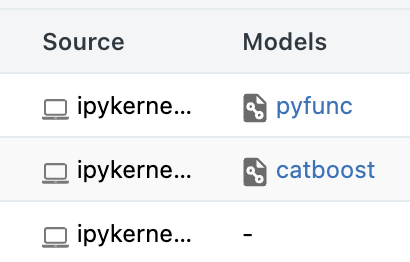

In [32]:
from IPython.display import Image

Image(filename="utils/images/models.png")